# Explore and process the single station dataset

This explanation was written after I'd finished with the dang exploration/processing. TL;DR: This entire dataset was mis-flagged, so I took the latter half of the dataset (after index 17500). I did a simple absolute-value-greater-than-threshold test to see where the anomalies were in the normalized readings. These anomalies included both "spikes" and "zeros" and were recorded in the anomaly index of the final saved dataset.

The first half of this notebook is me playing around with and exploring the data.

The second half is me preprocessing it to fit the format that the VAE-LSTM learner accepts.

In [1]:
import os
import csv
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure

In [2]:
# Load a single sensor into a pandas DataFrame object and preview its contents.
ssdf = pd.read_csv("1122sw2010_tseries.csv")
print(ssdf.columns)
ssdf.head()

Index(['WBAN', 'STATION_ID', 'UTC_START', 'TEMPERATURE', 'PRECIPITATION',
       'VARIABLE', 'VOLUMETRIC', 'NOPRCPRESPONSE', 'FROZENRECOVERY', 'NOISE',
       'FAILURE', 'STATIC', 'ERRATIC', 'DIURNALNOISE', 'TOOHIGH', 'SCALING',
       'ZERO', 'SPIKE', 'stVarId', 'flgCount', 'anyFlag'],
      dtype='object')


,WBAN,STATION_ID,UTC_START,TEMPERATURE,PRECIPITATION,VARIABLE,VOLUMETRIC,NOPRCPRESPONSE,FROZENRECOVERY,NOISE,...,STATIC,ERRATIC,DIURNALNOISE,TOOHIGH,SCALING,ZERO,SPIKE,stVarId,flgCount,anyFlag
0,63858,1122,2017-11-08 00:00:00,20.979,0.0,sw2010,0.469,0,0,0,...,0,0,0,0,0,0,0,1122sw2010,0,0
1,63858,1122,2017-11-08 01:00:00,21.090,0.0,sw2010,0.463,0,0,0,...,0,0,0,0,0,0,0,1122sw2010,0,0
2,63858,1122,2017-11-08 02:00:00,20.685,0.0,sw2010,0.460,0,0,0,...,0,0,0,0,0,0,0,1122sw2010,0,0
3,63858,1122,2017-11-08 03:00:00,20.612,0.0,sw2010,0.474,0,0,0,...,0,0,0,0,0,0,0,1122sw2010,0,0
4,63858,1122,2017-11-08 04:00:00,20.613,0.0,sw2010,0.468,0,0,0,...,0,0,0,0,0,0,0,1122sw2010,0,0


## Initial checks

In [3]:
# Check that this data all derives from a single sensor.
ssdf.VARIABLE.unique()

array(['sw2010'], dtype=object)

Confirmed that it derives from a single sensor.

In [4]:
# Find out how many flagged data points exist for this sensor.
print(ssdf.anyFlag.unique())
print(ssdf.anyFlag.sum())

[0 1]
2613


In [5]:
# Find how many locations exist with more than one flag.
print(ssdf.flgCount.unique())

[0 1]


In [6]:
# Count the number of different occurences for each anomaly type.
for flag_name in [
    "NOISE", "FAILURE", "STATIC", 
    "ERRATIC", "DIURNALNOISE", "TOOHIGH", 
    "SCALING", "ZERO", "SPIKE"]:
    
    print(f"{flag_name}:", ssdf[flag_name].unique(), ssdf[flag_name].sum())
    

NOISE: [0] 0
FAILURE: [0] 0
STATIC: [0] 0
ERRATIC: [0 1] 66
DIURNALNOISE: [0] 0
TOOHIGH: [0] 0
SCALING: [0] 0
ZERO: [0 1] 5
SPIKE: [0 1] 2542


In [7]:
# See at what indices the known anomalies occur.
idx_anomaly = ssdf.anyFlag[ssdf.anyFlag == 1].index.values
idx_spikes = ssdf.SPIKE[ssdf.SPIKE == 1].index.values
idx_erratic = ssdf.ERRATIC[ssdf.ERRATIC == 1].index.values
idx_zero = ssdf.ZERO[ssdf.ZERO == 1].index.values

print(idx_erratic)

print(idx_zero)

print(idx_spikes[:50])

[16705 16706 16707 16708 16709 16710 16711 16712 16713 16714 16715 16716
 16717 16718 16719 16720 16721 16722 16723 16724 16725 16726 16727 16728
 16729 16730 16731 16732 16733 16734 16735 16736 16737 16738 16739 16740
 16741 16742 16743 16744 16745 16746 16747 16748 16749 16750 16751 16752
 16753 16754 16755 16756 16757 16758 16759 16760 16761 16762 16763 16764
 16765 16766 16767 16768 16769 16770]
[24861 24863 25147 25863 25866]
[809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826
 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844
 845 846 847 848 849 850 851 852 853 854 855 856 857 858]


## Some data prep

In [ ]:
# all_columns = [
#     'WBAN', 'STATION_ID', 'TEMPERATURE', 'PRECIPITATION', 'VARIABLE',
#     'VOLUMETRIC', 'NOPRCPRESPONSE', 'FROZENRECOVERY', 'NOISE', 'FAILURE',
#     'STATIC', 'ERRATIC', 'DIURNALNOISE', 'TOOHIGH', 'SCALING', 'ZERO',
#     'SPIKE', 'stVarId', 'flgCount', 'anyFlag'
# ]
selected_columns = [
    'TEMPERATURE', 'PRECIPITATION', 'VARIABLE',
    'VOLUMETRIC', 'NOPRCPRESPONSE', 'FROZENRECOVERY', 'NOISE', 'FAILURE',
    'STATIC', 'ERRATIC', 'DIURNALNOISE', 'TOOHIGH', 'SCALING', 'ZERO',
    'SPIKE', 'stVarId', 'flgCount', 'anyFlag'
]

# Normalize and plot single sensor reads

In [170]:
# Define plotting vertical limits.
y_scale = 10

# idx_split = [0, 5200]
# idx_split = [800, 1000]
# idx_split = [17500, 33199]
idx_split = [17500, 23900]

t = [
    i for i in range(len(ssdf.index.values))
]

idx_anom_split = [
    aidx for aidx in idx_anomaly if (aidx>idx_split[0]) and (aidx<idx_split[1])
]

# plot the whole normalised sequence
fig, axs = plt.subplots(1, 1, figsize=(18, 4), edgecolor='k')
fig.subplots_adjust(hspace=.4, wspace=.4)
# axs = axs.ravel()
# for i in range(4):

axs.plot(t[idx_split[0]:idx_split[1]], ssdf.VOLUMETRIC.values[idx_split[0]:idx_split[1]])

# axs.plot(t, ssdf.VOLUMETRIC.values)

for j in range(len(idx_anom_split)):
    axs.plot(idx_anom_split[j]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'r--')

In [171]:
idx_split = [17500, 23900]

readings = ssdf.VOLUMETRIC.values
t = ssdf.index.values

# split into training and test sets
training = readings[idx_split[0]:idx_split[1]]
t_train = t[idx_split[0]:idx_split[1]]


In [172]:
# Normalise by training mean and std 
train_m = np.mean(training)
train_std = np.std(training)
print("\nTraining set mean is {}".format(train_m))
print("Training set std is {}".format(train_std))
readings_normalised = (readings - train_m) / train_std


Training set mean is 0.44379484375000006
Training set std is 0.04079043934751237


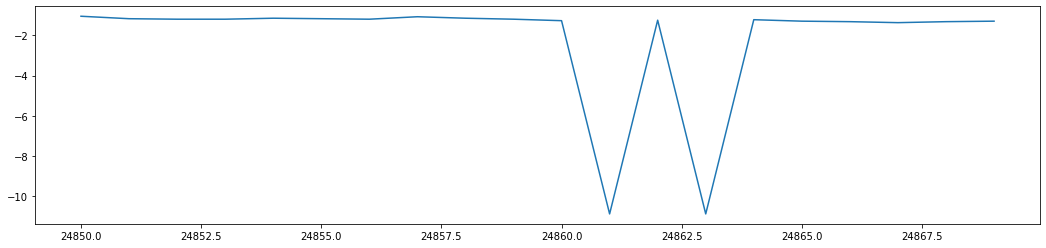

In [173]:
# plot the whole normalised sequence
fig, axs = plt.subplots(1, 1, figsize=(18, 4), edgecolor='k')
fig.subplots_adjust(hspace=.4, wspace=.4)
# axs = axs.ravel()
# for i in range(4):

# axs.plot(t[idx_split[0]:idx_split[1]], readings_normalised[idx_split[0]:idx_split[1]])
# axs.plot(t, readings_normalised)
# axs.plot(t[idx_split[0]:], readings_normalised[idx_split[0]:])

# idx_start, idx_stop = 23900, 26000
# idx_start, idx_stop = 31000, 32000
idx_start, idx_stop = 24850, 24870

axs.plot(t[idx_start:idx_stop], readings_normalised[idx_start:idx_stop])

# axs.plot(t, ssdf.VOLUMETRIC.values)

for j in range(len(idx_anom_split)):
    axs.plot(idx_anom_split[j]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'r--')

In [166]:
idx_zero

array([24861, 24863, 25147, 25863, 25866])

#### Find indices of unflagged spikes

In [100]:
for idx, reading in zip(t[17500:], readings_normalised[17500:]):
    if abs(reading) > 8:
        print(idx)

23935
24861
24863
25147
25863
25866
31043
31045
31046
31047
31051
31052
31053
31054
31055
31056
31057
31063
31064
31066
31067
31070
31148
31149
31150
31151
31152
31153
31156
31174
32479


In [115]:
# old_anom_idx_list = [
#     23935, 24861, 24863, 25147, 25863, 
#     25866, 31043, 31045, 31046, 31047, 
#     31051, 31052, 31053, 31054, 31055, 
#     31056, 31057, 31063, 31064, 31066, 
#     31067, 31070, 31148, 31149, 31150, 
#     31151, 31152, 31153, 31156, 31174, 32479
# ]

# Preprocess the single station dataset and save it for training


Training set mean is 0.44379484375000006
Training set std is 0.04079043934751237


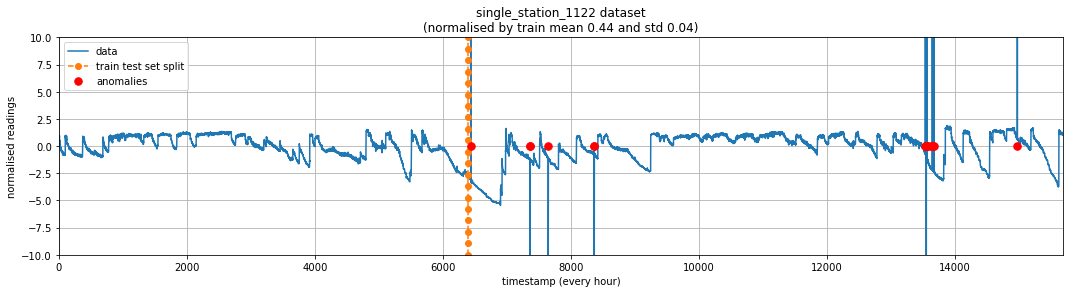

In [185]:
save_file = False
t_unit = "hour" 
dataset = "single_station_1122"

ssdf = pd.read_csv("1122sw2010_tseries.csv")

idx_start = 17500
idx_stop = ssdf.shape[0]

ssdf = ssdf.iloc[idx_start:]
ssdf = ssdf.reset_index()

t = ssdf.index.values + 1
readings = ssdf.VOLUMETRIC.values

idx_train_start = 0
idx_train_stop = 23900 - 17500

idx_split = [idx_train_start, idx_train_stop]

training = readings[idx_split[0]:idx_split[1]]
t_train = t[idx_split[0]:idx_split[1]]

# normalise by training mean and std 
train_m = np.mean(training)
train_std = np.std(training)
print("\nTraining set mean is {}".format(train_m))
print("Training set std is {}".format(train_std))
readings_normalised = (readings - train_m) / train_std

idx_anomaly = []
for idx, reading in zip(t, readings_normalised):
    if abs(reading) > 8:
        idx_anomaly.append(idx-1)

        
# print(readings_normalised[idx_anom])

training = readings_normalised[idx_split[0]:idx_split[1]]

test = readings_normalised[idx_split[1]:]
t_test = t[idx_split[1]:] - idx_split[1]
idx_anomaly_test = np.asarray(idx_anomaly) - idx_split[1]

if save_file:
    save_dir = './NAB-known-anomaly/'
    np.savez(
        save_dir+dataset+'.npz', t=t, t_unit=t_unit,
        readings=readings, idx_anomaly=idx_anomaly,
        idx_split=idx_split, training=training,
        test=test, train_m=train_m, train_std=train_std,
        t_train=t_train, t_test=t_test,
        idx_anomaly_test=idx_anomaly_test
    )
    print("\nProcessed time series are saved at {}".format(save_dir+dataset+'.npz'))

y_scale = 10

# plot the whole normalised sequence
fig, axs = plt.subplots(1, 1, figsize=(18, 4), edgecolor='k')
fig.subplots_adjust(hspace=.4, wspace=.4)
# axs = axs.ravel()
# for i in range(4):


axs.plot(t, readings_normalised)
if idx_split[0] == 0:
    axs.plot(idx_split[1]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'o--')
else:
    for i in range(2):
        axs.plot(idx_split[i]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'b--')

        
for j in range(len(idx_anomaly)):
#     axs.plot(idx_anomaly[j]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'r--')
    axs.plot(idx_anomaly[j], 0, 'r.', markersize=15)


#     axs.plot(data[:,1])
axs.grid(True)
axs.set_xlim(0, len(t))
axs.set_ylim(-y_scale, y_scale)
axs.set_xlabel("timestamp (every {})".format(t_unit))
axs.set_ylabel("normalised readings")
axs.set_title("{} dataset\n(normalised by train mean {:.2f} and std {:.2f})".format(dataset, train_m, train_std))
axs.legend(('data', 'train test set split', 'anomalies'))